In [1]:
import pandas as pd # Таблицы
import numpy as np # Математика и массивы
import matplotlib.pyplot as plt # Графики и диаграммы
import seaborn as sns # Графики и диаграммы
import scipy.stats as stats # Статистика

In [2]:
data = pd.read_csv('data_2017_taxi.csv', sep=',', index_col=0).\
    reset_index(drop=True)

data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount
0,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,16.56
1,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,20.80
2,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,8.75
3,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,27.69
4,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,17.80


## Данные о поездках на такси в Нью-Йорке

Задача для регрессии:
- Предсказать цену поездки на такси

Задача для классификации:
- Предсказать больше ли цена на такси медианной цены на такси

Задача для кластеризации:
- Разделить поездки на максимально непохожие друг на друга кластеры и убедиться, что кластеры друг от друга различны


## Описание Колонок Данных

- **VendorID**: Код поставщика TPEP. 1 = Creative Mobile Technologies, LLC; 2 = VeriFone Inc.
- **tpep_pickup_datetime**: Дата и время начала поездки
- **tpep_dropoff_datetime**: Дата и время окончания поездки
- **Passenger_count**: Количество пассажиров в транспортном средстве (значение, введенное водителем)
- **Trip_distance**: Пройденное расстояние в милях, как указано на таксометре
- **PULocationID**: Зона TLC Taxi (географические сегменты в Нью-Йорке), в которой таксометр был активирован
- **DOLocationID**: Зона TLC Taxi, в которой таксометр был деактивирован
- **RateCodeID**: Итоговый код тарифа. 1 = Стандартный тариф, 2 = JFK (аэропорт), 3 = Newark (аэропорт), 4 = Nassau или Westchester (округи), 5 = Договорная стоимость, 6 = Групповая поездка
- **Store_and_fwd_flag**: Флаг, указывающий, хранились ли данные о поездке в памяти транспортного средства перед отправкой поставщику. Y = хранились, N = не хранились (Если хранились - соединения сетью во время поездки не было)
- **Payment_type**: Числовой код, указывающий, как пассажир оплатил поездку. 1 = Кредитная карта, 2 = Наличные, 3 = Без оплаты, 4 = Спор, 5 = Неизвестно, 6 = Аннулированная поездка
- **Total_amount**: Общая сумма, взимаемая с пассажиров. Не включает чаевые, оплаченные наличными


In [3]:
data.info() #Выведу информацию о каждом столбце  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               22699 non-null  int64  
 1   tpep_pickup_datetime   22699 non-null  object 
 2   tpep_dropoff_datetime  22699 non-null  object 
 3   passenger_count        22699 non-null  int64  
 4   trip_distance          22699 non-null  float64
 5   RatecodeID             22699 non-null  int64  
 6   store_and_fwd_flag     22699 non-null  object 
 7   PULocationID           22699 non-null  int64  
 8   DOLocationID           22699 non-null  int64  
 9   payment_type           22699 non-null  int64  
 10  total_amount           22699 non-null  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 1.9+ MB


In [4]:
print(f"""В данных {data.shape[0]} наблюдений и {data.shape[1]} признаков""")

В данных 22699 наблюдений и 11 признаков


Удаление пропусков и повторяющихся значений

In [5]:
data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

Пропусков нет

In [6]:
data.duplicated().sum()

0

Дубликатов нет

## Предварительная обработка

Обработка дат

In [7]:
#Приведу даты в формат datetime
data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime)
data.tpep_dropoff_datetime = pd.to_datetime(data.tpep_dropoff_datetime)

Создам новые переменные из дат

In [8]:
#Время поездки в секундах
data['trip_seconds'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
data['trip_seconds'] = data['trip_seconds'].dt.seconds

#Час начала поездки
data['pickup_hour'] = data.tpep_pickup_datetime.dt.hour

#Месяц поездки
data['month'] = data.tpep_pickup_datetime.dt.month_name()

#День недели
data['day_of_week'] = data.tpep_pickup_datetime.dt.day_name()

#День месяца
data['day_of_month'] = data.tpep_pickup_datetime.dt.day

#Удалю ненужные переменные
data = data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

In [9]:
data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,trip_seconds,pickup_hour,month,day_of_week,day_of_month
0,2,6,3.34,1,N,100,231,1,16.56,844,8,March,Saturday,25
1,1,1,1.80,1,N,186,43,1,20.80,1590,14,April,Tuesday,11
2,1,1,1.00,1,N,262,236,1,8.75,432,7,December,Friday,15
3,2,1,3.70,1,N,188,97,1,27.69,1815,13,May,Sunday,7
4,2,1,4.37,1,N,4,112,2,17.80,1003,23,April,Saturday,15


# Описательные статистики

In [10]:
num_var = ['passenger_count', 'trip_distance', 'total_amount', 'trip_seconds']

In [11]:
data[num_var].describe()

,passenger_count,trip_distance,total_amount,trip_seconds
count,22699.000000,22699.000000,22699.000000,22699.000000
mean,1.642319,2.913313,16.310502,1024.632935
std,1.285231,3.653171,16.097295,3761.670875
min,0.000000,0.000000,-120.300000,0.000000
25%,1.000000,0.990000,8.750000,399.000000
50%,1.000000,1.610000,11.800000,671.000000
75%,2.000000,3.060000,17.800000,1103.000000
max,6.000000,33.960000,1200.290000,86373.000000


Мы видим аномальные отрицательные значения в стоимости такси. Скорее всего это ошибка в данных. Поэтому наблюдения можно удалить

In [12]:
data = data[data['total_amount'] > 0]

Monthly Revenue (Месячный доход)

In [13]:
# Делаю переменную порядковой в pandas, чтобы визуализировать
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['month'] = pd.Categorical(data['month'], categories=ordered_months, ordered=True)

<Axes: xlabel='month', ylabel='total_amount'>

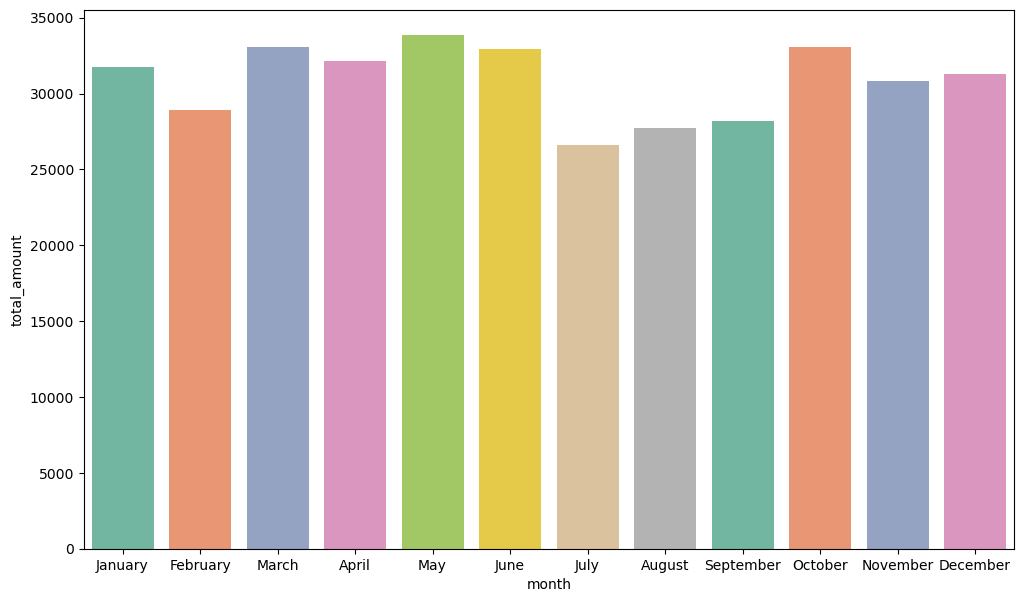

In [14]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=data, 
    x='month', 
    y='total_amount', 
    estimator='sum', 
    errorbar=None,
    palette='Set2'
)

Наблюдаем самый низкий доход в июле, а самый высокий - в мае

Daily revenue (Дневная выручка)

<Axes: xlabel='day_of_month', ylabel='total_amount'>

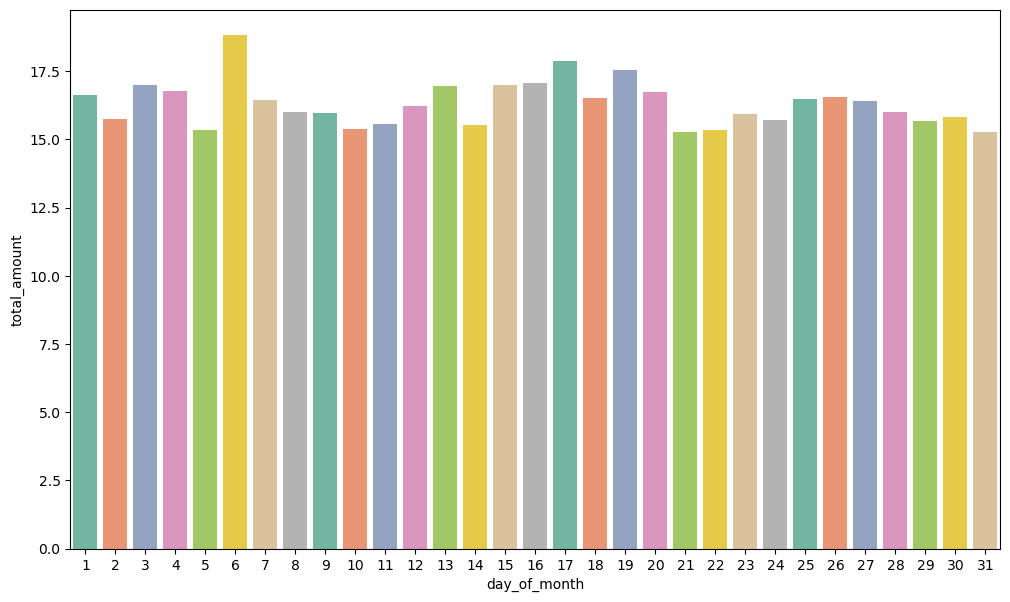

In [15]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=data, 
    x='day_of_month', 
    y='total_amount', 
    estimator='mean',
    errorbar=None,
    palette='Set2'
)

Видно, что самую большую выручку с такси компании получили 3го, 17го и 19го числа

Почасовая стоимость такси

Text(0.5, 1.0, 'Сумма дохода')

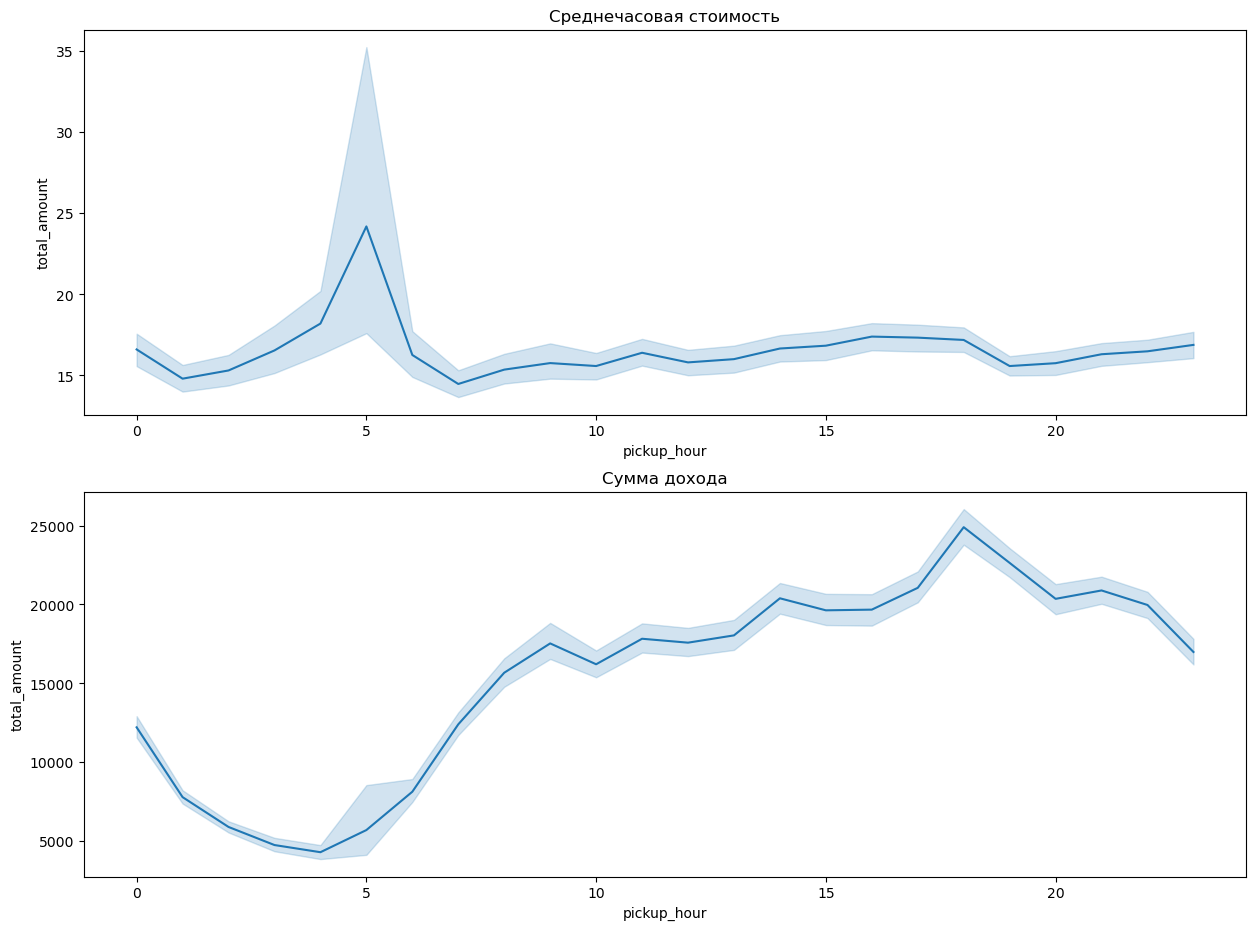

In [16]:
fig, ax = plt.subplots(2, figsize=(15, 11))

sns.lineplot(data=data, 
             x='pickup_hour', 
             y='total_amount', 
             estimator='mean', 
             ax=ax[0])
ax[0].set_title('Среднечасовая стоимость')

sns.lineplot(data=data, 
             x='pickup_hour', 
             y='total_amount', 
             estimator='sum', 
             ax=ax[1])
ax[1].set_title('Сумма дохода')

Видно, что самый сильный подъём в средней стоимости такси появляется в районе 5ти утра. Тогда же компании зарабатывают меньше всего, так как и заказов меньше всего. 

В дневное же время, самая большая средняя цена в районе 17:00 - 18:00. Тогда же и компании получают большую выгоду за день

Средняя стоимость поездки по дням недели:

<Axes: xlabel='day_of_week', ylabel='total_amount'>

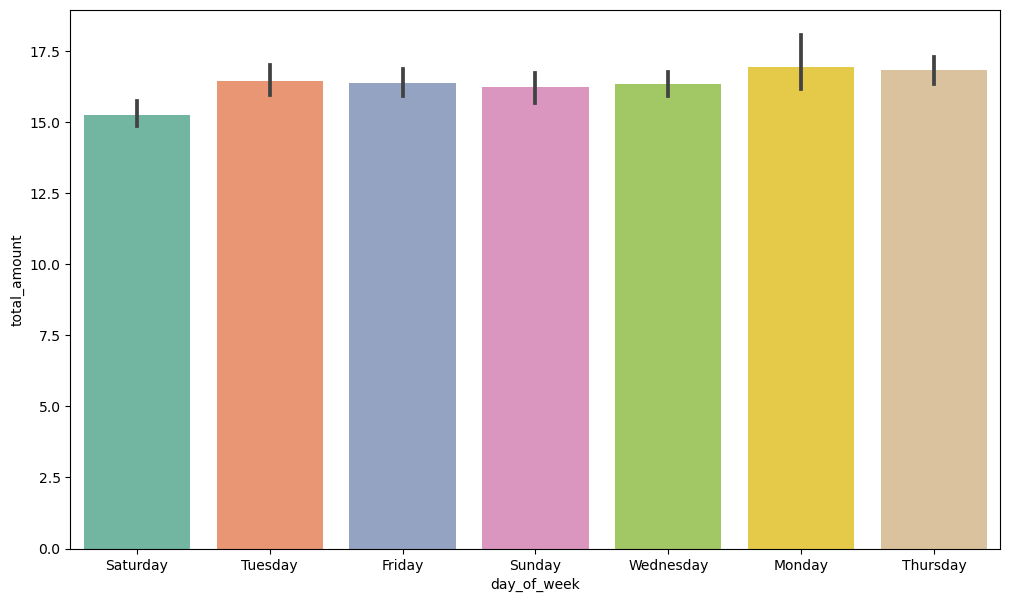

In [17]:
plt.figure(figsize=(12, 7))
sns.barplot(
    data=data, 
    x='day_of_week', 
    y='total_amount',
    palette='Set2'
)

Мы видим, что в субботу средняя стоимость такси значительно ниже, чем в другие дни. В остальные же дни, средняя цена поездки сильно не отличается друг от друга

# Обработка

In [18]:
data.RatecodeID.value_counts()

1     22053
2       513
5        67
3        39
4         8
99        1
Name: RatecodeID, dtype: int64

In [19]:
data.store_and_fwd_flag.value_counts()

N    22582
Y       99
Name: store_and_fwd_flag, dtype: int64

Кодирую категориальные признаки

In [20]:
from sklearn.preprocessing import LabelEncoder

for i in ['store_and_fwd_flag', 'month', 'day_of_week']:
    data[i] = LabelEncoder().fit_transform(data[i])

Выделю целевой признак

In [21]:
y = data['total_amount']
X = data.drop('total_amount', axis=1)

Стандартизирую данные

In [22]:
X = stats.zscore(X)

In [23]:
X.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,trip_seconds,pickup_hour,month,day_of_week,day_of_month
0,0.893833,3.390934,0.116279,-0.061076,-0.066212,-0.936664,0.990309,-0.680269,-0.047701,-0.920413,0.429008,-0.506263,1.078430
1,-1.118777,-0.499843,-0.305214,-0.061076,-0.066212,0.354171,-1.690057,-0.680269,0.152692,0.043750,-1.606077,0.979830,-0.527414
2,-1.118777,-0.499843,-0.524171,-0.061076,-0.066212,1.494909,1.061595,-0.680269,-0.158374,-1.081106,-1.024624,-1.496991,-0.068601
3,0.893833,-0.499843,0.214809,-0.061076,-0.066212,0.384191,-0.920165,-0.680269,0.213132,-0.116944,0.719734,-0.010898,-0.986227
4,0.893833,-0.499843,0.398186,-0.061076,-0.066212,-2.377596,-0.706306,1.346952,-0.004990,1.489993,-1.606077,-0.506263,-0.068601


Удалю выбросы методом 3 IQR

In [24]:
for column in X.columns:
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # Интерквартильный размах
    upper_bound = Q3 + 1.5 * IQR
    filter = (X[column] >= lower_bound) & (X[column] <= upper_bound)
    X = X.loc[filter]

y = y[X.index]

# Корреляционный анализ

Проанализирую корреляции для регрессоров. 

Если корреляция двух регрессоров будет близка к 1, удалю один из них, чтобы избавиться от мультиколлинеарности. 

Буду считать, что близкая к единице корреляция - это корреляция > 0.8

In [25]:
X.corr() # Корреляционная матрица

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,trip_seconds,pickup_hour,month,day_of_week,day_of_month
VendorID,1.000000,0.098506,0.019447,NaN,NaN,-0.023785,-0.029787,-0.003524,-0.007872,0.001662,-0.005169,-0.000166,0.002404
passenger_count,0.098506,1.000000,0.029330,NaN,NaN,-0.021488,-0.001343,0.024995,0.027258,0.033037,-0.006615,-0.027214,-0.007069
trip_distance,0.019447,0.029330,1.000000,NaN,NaN,-0.051563,-0.091615,-0.077188,0.706767,-0.013792,-0.011591,-0.017978,-0.014872
RatecodeID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_and_fwd_flag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PULocationID,-0.023785,-0.021488,-0.051563,NaN,NaN,1.000000,0.102184,-0.004636,-0.028299,0.036564,0.002639,0.021284,0.017682
DOLocationID,-0.029787,-0.001343,-0.091615,NaN,NaN,0.102184,1.000000,-0.003995,-0.044641,0.014205,-0.006390,0.027131,0.003291
payment_type,-0.003524,0.024995,-0.077188,NaN,NaN,-0.004636,-0.003995,1.000000,-0.067107,-0.021670,-0.017997,-0.023185,0.010337
trip_seconds,-0.007872,0.027258,0.706767,NaN,NaN,-0.028299,-0.044641,-0.067107,1.000000,0.068415,0.013245,0.023226,-0.006763
pickup_hour,0.001662,0.033037,-0.013792,NaN,NaN,0.036564,0.014205,-0.021670,0.068415,1.000000,0.005459,0.025668,0.010738


После удаления выбросов получилось так, что категориальные переменные RatecodeID и store_and_fwd_flag принимают только одно значение, так как матрица показывает NaN

In [26]:
X.nunique() # Смотрю на количество классов для каждой переменной 

VendorID                 2
passenger_count          4
trip_distance          596
RatecodeID               1
store_and_fwd_flag       1
PULocationID           129
DOLocationID           156
payment_type             3
trip_seconds          1697
pickup_hour             24
month                   12
day_of_week              7
day_of_month            31
dtype: int64

Подтвержается, что они принимают только одно значение. Я могу удалить их из данных. 

In [27]:
X = X.drop(['RatecodeID', 'store_and_fwd_flag'], axis=1)

X.corr()

,VendorID,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,trip_seconds,pickup_hour,month,day_of_week,day_of_month
VendorID,1.000000,0.098506,0.019447,-0.023785,-0.029787,-0.003524,-0.007872,0.001662,-0.005169,-0.000166,0.002404
passenger_count,0.098506,1.000000,0.029330,-0.021488,-0.001343,0.024995,0.027258,0.033037,-0.006615,-0.027214,-0.007069
trip_distance,0.019447,0.029330,1.000000,-0.051563,-0.091615,-0.077188,0.706767,-0.013792,-0.011591,-0.017978,-0.014872
PULocationID,-0.023785,-0.021488,-0.051563,1.000000,0.102184,-0.004636,-0.028299,0.036564,0.002639,0.021284,0.017682
DOLocationID,-0.029787,-0.001343,-0.091615,0.102184,1.000000,-0.003995,-0.044641,0.014205,-0.006390,0.027131,0.003291
payment_type,-0.003524,0.024995,-0.077188,-0.004636,-0.003995,1.000000,-0.067107,-0.021670,-0.017997,-0.023185,0.010337
trip_seconds,-0.007872,0.027258,0.706767,-0.028299,-0.044641,-0.067107,1.000000,0.068415,0.013245,0.023226,-0.006763
pickup_hour,0.001662,0.033037,-0.013792,0.036564,0.014205,-0.021670,0.068415,1.000000,0.005459,0.025668,0.010738
month,-0.005169,-0.006615,-0.011591,0.002639,-0.006390,-0.017997,0.013245,0.005459,1.000000,-0.000501,0.021693
day_of_week,-0.000166,-0.027214,-0.017978,0.021284,0.027131,-0.023185,0.023226,0.025668,-0.000501,1.000000,0.003631


In [28]:
(X.corr() > 0.8).sum() > 1

VendorID           False
passenger_count    False
trip_distance      False
PULocationID       False
DOLocationID       False
payment_type       False
trip_seconds       False
pickup_hour        False
month              False
day_of_week        False
day_of_month       False
dtype: bool

Не наблюдается корреляции выше 0.8, что говорит о том, что мультиколлинеарности в данных нет 

# Линейная регрессия

In [29]:
from sklearn.model_selection import train_test_split
from statsmodels.api import add_constant

X = add_constant(X) # Добавили вектор единиц к данным

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [30]:
from statsmodels.api import OLS # Линейная регрессия

ols = OLS(y_train, X_train)
fitted_ols = ols.fit()

print(fitted_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 1.954e+04
Date:                Fri, 27 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:17:42   Log-Likelihood:                -22206.
No. Observations:               13886   AIC:                         4.444e+04
Df Residuals:                   13874   BIC:                         4.453e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              16.6072      0.016   10

- Модель на обучающих данных объясняет 94% дисперсии зависимой переменной.
- На уровне значимости 5% регрессия в целом значима
- Существуют незначимые признаки на уровне значимости 5%

Удалю незначимые признаки и заново обучу модель:

In [31]:
pvalues = pd.Series(fitted_ols.pvalues)
significant_features = pvalues[pvalues < 0.05].index # Значимые признаки

X_train = X_train[significant_features]
X_test = X_test[significant_features]

In [32]:
ols = OLS(y_train, X_train)
fitted_ols = ols.fit()

print(fitted_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 3.583e+04
Date:                Fri, 27 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:17:42   Log-Likelihood:                -22207.
No. Observations:               13886   AIC:                         4.443e+04
Df Residuals:                   13879   BIC:                         4.448e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            16.6128      0.015   1121.936

Видно, что модель хуже не стала. Признаки были удалены правильно.

Самым влиятельным признаком яляется время поездки, когда как самым невлиятельным из значимых является день недели

Оценю модель на тестовых данных:

In [33]:
y_pred = fitted_ols.predict(X_test)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

print(f"""MAE: {mean_absolute_error(y_test, y_pred)}
MAPE: {mean_absolute_percentage_error(y_test, y_pred)}
R^2: {r2_score(y_test, y_pred)}
""")

MAE: 0.7088955034121306
MAPE: 0.06325398209552971
R^2: 0.9489256173349722



- Мы видим, что на нашей тестовой выборке модель описывает данные лучше, чем на обучающей. 
- В среднем, ошибка отклоняется от истинного значения на 6%

Text(0, 0.5, 'Предсказания')

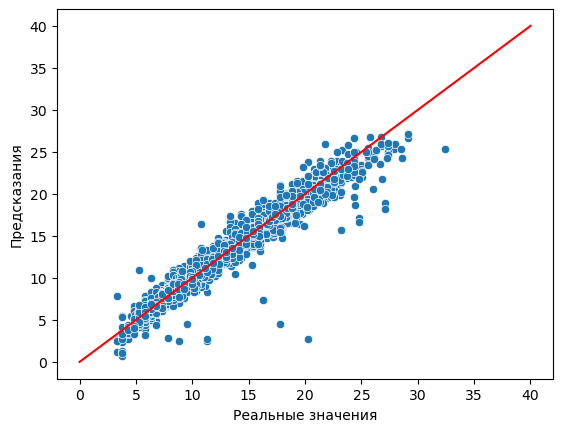

In [35]:
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, 40], [0, 40], c='r')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')

Графически видно, что модель хорошая и наблюдения сконцентрированны у красной линии, что есть хорошо

**Тест на нормальность ошибок**

H0 -> errors ~ N

H1 -> errors любые другие

In [36]:
errors = y_pred - y_test

stats.shapiro(errors)

ShapiroResult(statistic=0.8283339738845825, pvalue=0.0)

Пусть alpha = 0.05, тогда p-value < alpha, следовательно мы отвергаем H0 и считаем данные ненормальными

<Axes: ylabel='Count'>

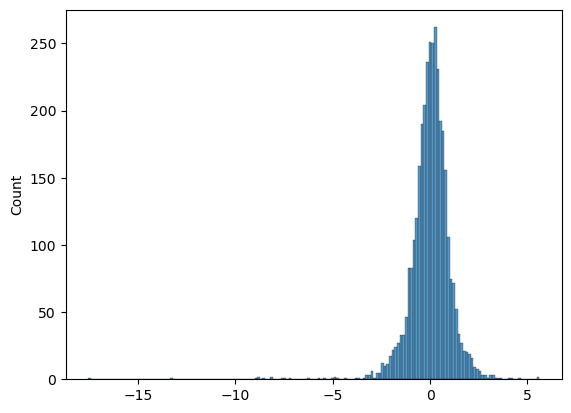

In [37]:
sns.histplot(errors)

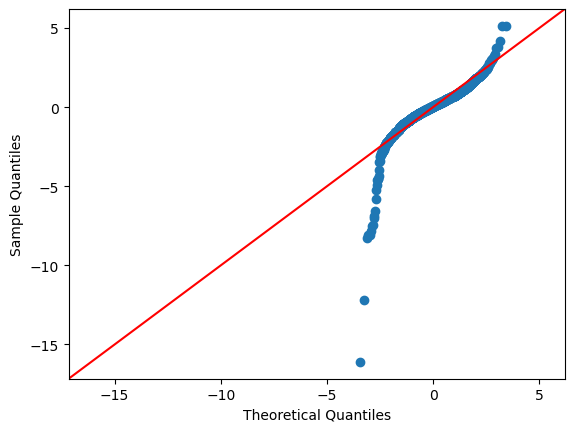

In [38]:
from statsmodels.api import qqplot  # Квнтиль-квантиль плот

qqplot(errors, line='45', fit=True)
plt.show()

Мы видим, что есть большие отклонения от красной линии, которая говорит об идеальном нормальном распределении. Видны сильные выбросы в отрицательную сторону

Вывод:

- Была построена модель, которая может с хорошей точностью может предсказывать цену на такси

# Регрессия с регуляризацией

Для того, чтобы сделать модель более устойчивую к изменениям в данных, используем регуляризатор, который будет штрафовать модель за большие веса. 

In [39]:
from sklearn.linear_model import RidgeCV 

ridge = RidgeCV(
    alphas=np.linspace(0.001, 10, 100), 
    cv=4 # Количество фолдов кросс-валидации
)

ridge.fit(X_train, y_train)
ridge.alpha_

0.001

In [40]:
y_pred_ridge = ridge.predict(X_test)

print(f"""MAE: {mean_absolute_error(y_test, y_pred_ridge)}
MAPE: {mean_absolute_percentage_error(y_test, y_pred_ridge)}
R^2: {r2_score(y_test, y_pred_ridge)}
""")

MAE: 0.7088963737361927
MAPE: 0.06325406531872317
R^2: 0.9489256022951658



Мы видим, что модель получилась такой же, как и модель классической регрессии. Связано это с тем, что коэффициент регуляризации после обучения принял самое наименьшее значение. Значит регуляризация почти не влияет на модель, а если будет влиять, то будет влиять отрицательно  

Text(0, 0.5, 'Предсказания')

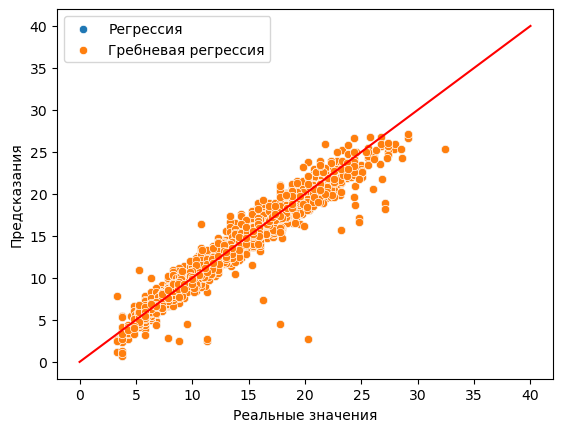

In [41]:
sns.scatterplot(x=y_test, y=y_pred, label='Регрессия')
sns.scatterplot(x=y_test, y=y_pred_ridge, label='Гребневая регрессия')
plt.plot([0, 40], [0, 40], c='r')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')

Видно, что предсказания после регуляризации абсолютно совпали с классичесуой регрессией

# Логистическая регрессия

Перезапишу целевой признак в бинарный

In [42]:
y_median = pd.concat([y_train, y_test]).median()

y_train = np.where(y_train > y_median, 1, 0)
y_test = np.where(y_test > y_median, 1, 0)

Обучу модель и получу метрики качества

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() #ravel преобразовывает многомерный массив в одномерный

print(f"""
Матрица ошибок:
TP = {tp}  FP = {fp}
FN = {fn}   TN = {tn}

Метрики качества:
accuracy = {accuracy_score(y_test, y_pred)}
precision = {precision_score(y_test, y_pred)}
recall = {recall_score(y_test, y_pred)}
f1 = {f1_score(y_test, y_pred)}
""")


Матрица ошибок:
TP = 1638  FP = 82
FN = 98   TN = 1654

Метрики качества:
accuracy = 0.9481566820276498
precision = 0.9523255813953488
recall = 0.9435483870967742
f1 = 0.9479166666666666



- True Positive (TP): Количество правильно классифицированных положительных примеров.
- True Negative (TN): Количество правильно классифицированных отрицательных примеров.
- False Positive (FP): Количество отрицательных примеров, неверно классифицированных как положительные.
- False Negative (FN): Количество положительных примеров, неверно классифицированных как отрицательные.

Видно, что 95% предсказаний верны, что является хорошим результатом

# Случайный лес

In [44]:
from sklearn.ensemble import RandomForestClassifier

lr = RandomForestClassifier()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

print(f"""
TP = {tp}  FP = {fp}
FN = {fn}   TN = {tn}

accuracy = {accuracy_score(y_test, y_pred)}
precision = {precision_score(y_test, y_pred)}
recall = {recall_score(y_test, y_pred)}
f1 = {f1_score(y_test, y_pred)}
""")


TP = 1668  FP = 85
FN = 68   TN = 1651

accuracy = 0.9559331797235023
precision = 0.9515116942384484
recall = 0.9608294930875576
f1 = 0.9561478933791918



Мы видим, что случайный лес, обученный на стандартных параметрах, показывает результаты лучше логистической регрессии. Для классификации лучше использовать его.

# Кластеризация

Создам датафрейм для кластеризации

In [45]:
data_claster = pd.concat(
    [X, stats.zscore(y)], 
    axis=1
)

Определю оптимальное число кластеров

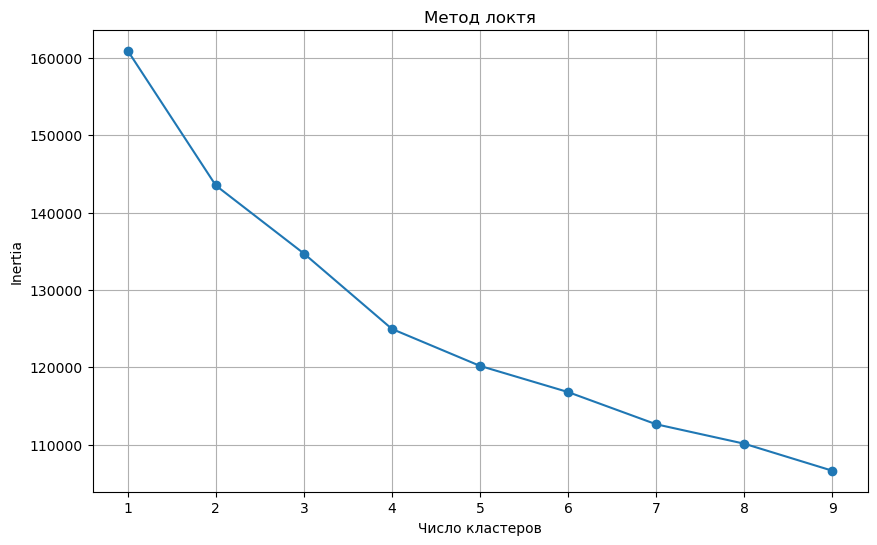

In [46]:
from sklearn.cluster import KMeans

inertia_values = []

for k in range(1, 10):
    model = KMeans(n_clusters=k, n_init='auto', random_state=16)
    model.fit(data_claster)
    inertia_values.append(model.inertia_)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia_values, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.xticks(range(1, 10))
plt.grid(True)
plt.show()

Самый сильный изгиб график приобретает в точке 4. Поэтому построю кластеризацию по 4рём кластерам

In [47]:
kmeans = KMeans(n_clusters=4, n_init='auto', random_state=16)
kmeans.fit(data_claster)

pd.Series(kmeans.labels_).value_counts() # Выведу сколько наблюдений попало в каждый из кластеров

0    5350
3    4804
1    4590
2    2614
dtype: int64

Средняя цена поездки в каждом из кластеров

<Axes: ylabel='total_amount'>

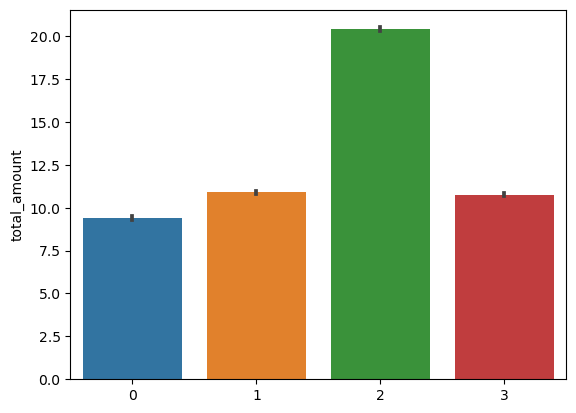

In [48]:
sns.barplot(x=kmeans.labels_, y=y)

Один кластер имеет гораздо более высокую среднюю стоимость поездки, чем остальные, и один из кластеров - ниже, чем оставшиеся два